In [7]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import pandas as pd
from sqlalchemy import create_engine
from urllib.parse import quote_plus

# DB 접속 정보
user = "lguplus7"
password = quote_plus("lg7p@ssw0rd~!")   # 특수문자 처리
host = "localhost"
port = 3310
db = "bangu"

# SQLAlchemy 엔진 생성
engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}:{port}/{db}?charset=utf8mb4")

# room 테이블 읽기
df = pd.read_sql("SELECT * FROM room", engine)

print("가져온 행 수:", len(df))

# CSV 저장
df.to_csv("room_export.csv", index=False, encoding="utf-8-sig")
print("✅ room_export.csv 파일로 저장 완료")


가져온 행 수: 303
✅ room_export.csv 파일로 저장 완료


In [6]:
df = pd.read_csv("room_export.csv")

#print(df.head())   # 처음 5행 미리보기
print(df.info())   # 컬럼 정보
#print(df.describe())  # 기본 통계량


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 27 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   303 non-null    int64  
 1   property_url         303 non-null    object 
 2   transaction_type     303 non-null    object 
 3   deposit              303 non-null    int64  
 4   rent                 303 non-null    int64  
 5   management_fee       286 non-null    float64
 6   loan_amount          302 non-null    object 
 7   move_in_date         303 non-null    object 
 8   residence_report     303 non-null    object 
 9   building_usage       302 non-null    object 
 10  building_type        251 non-null    object 
 11  exclusive_area       303 non-null    float64
 12  floor_info           303 non-null    object 
 13  room_bathroom_count  303 non-null    object 
 14  room_living_type     300 non-null    object 
 15  main_room_direction  302 non-null    obj

In [2]:
import pandas as pd

# CSV 파일 불러오기 (인코딩 지정)
df = pd.read_csv("room_trade.csv", encoding="cp949")

# 데이터 기본 구조 확인
print("행/열 크기:", df.shape)

행/열 크기: (141525, 18)


C:\Users\Admin\AppData\Local\Temp\ipykernel_19936\3541156372.py:4: DtypeWarning: Columns (9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("room_trade.csv", encoding="cp949")


In [3]:
print("\n상위 5행:\n", df.head())


상위 5행:
    NO              시군구   번지  도로조건  계약면적(㎡) 전월세구분    계약년월  계약일 보증금(만원) 월세금(만원)  \
0   1     서울특별시 중구 신당동  3**  8m미만    16.50    월세  202508   27   1,000      50   
1   2    서울특별시 용산구 서계동  2**  8m미만    59.00    전세  202508   27  14,170       0   
2   3    서울특별시 용산구 보광동  2**  8m미만    74.83    전세  202508   27  30,000       0   
3   4    서울특별시 용산구 남영동   7*  8m미만    24.00    전세  202508   27  17,000       0   
4   5  서울특별시 용산구 원효로1가   2*  8m미만    32.81    월세  202508   27   1,000      60   

     건축년도      도로명           계약기간 계약구분 갱신요구권 사용 종전계약 보증금(만원) 종전계약 월세(만원)  \
0  1990.0   다산로14길  202511~202711   신규        -          NaN         NaN   
1  2001.0  만리재로26길  202508~202509   신규        -          NaN         NaN   
2  1990.0   보광로21길  202508~202708   신규        -          NaN         NaN   
3  1956.0  한강대로80길  202510~202710   갱신       사용       17,000         0.0   
4  1994.0   원효로81길  202509~202709   신규        -          NaN         NaN   

    주택유형  
0  단독다가구  
1  단독다가구  
2  단독다가구  
3  

In [5]:
import pandas as pd

# 공급 데이터
room_df = pd.read_csv("room_export.csv", encoding="utf-8-sig")

# 실거래 데이터
trade_df = pd.read_csv("room_trade.csv", encoding="cp949")

print("room_df:", room_df.shape)
print("trade_df:", trade_df.shape)


room_df: (303, 27)
trade_df: (141525, 18)


C:\Users\Admin\AppData\Local\Temp\ipykernel_19936\3148217494.py:7: DtypeWarning: Columns (9,16) have mixed types. Specify dtype option on import or set low_memory=False.
  trade_df = pd.read_csv("room_trade.csv", encoding="cp949")


## room_export 전처리

In [11]:
import re

# ① 전용면적 숫자화
room_df["exclusive_area"] = (
    room_df["exclusive_area"].astype(str).str.extract(r"([\d\.]+)").astype(float)
)


# ② 층수 분리
room_df[["floor", "total_floor"]] = room_df["floor_info"].astype(str).str.extract(r"(\d+)[^\d]+(\d+)")
room_df["floor"] = pd.to_numeric(room_df["floor"], errors="coerce")
room_df["total_floor"] = pd.to_numeric(room_df["total_floor"], errors="coerce")


# ③ 관리비 전처리
def parse_fee(x):
    if pd.isna(x) or "없음" in str(x): 
        return 0
    x = str(x).replace("만원","").replace(",","").strip()
    try: 
        return float(x) * 10000
    except: 
        return None

room_df["management_fee"] = room_df["management_fee"].apply(parse_fee)

# ④ 준공년도
room_df["completion_year"] = pd.to_datetime(
    room_df["completion_date"], errors="coerce"
).dt.year

# ⑤ 옵션 개수
for col in ["additional_options", "living_facilities", "security_facilities"]:
    room_df[col + "_count"] = room_df[col].apply(
        lambda x: len(str(x).split(",")) if pd.notna(x) and str(x).strip() != "" else 0
    )

# ⑥ 옵션/시설 개수 
for col in ["additional_options", "living_facilities", "security_facilities"]:
    room_df[col + "_count"] = room_df[col].apply(
        lambda x: len(str(x).split(",")) if pd.notna(x) and str(x).strip() != "" else 0
    )
    
# 주소에서 '동' 추출

room_df["dong"] = room_df["property_address"].astype(str).str.extract(r"([가-힣]+동)")



## room_trade 전처리

In [12]:
trade_df["계약면적(㎡)"] = pd.to_numeric(trade_df["계약면적(㎡)"], errors="coerce")

trade_df["보증금(만원)"] = (
    trade_df["보증금(만원)"].astype(str).str.replace(",","").astype(float) * 10000
)

trade_df["월세금(만원)"] = (
    trade_df["월세금(만원)"].astype(str).str.replace(",","").astype(float) * 10000
)

trade_df["환산금액"] = trade_df["보증금(만원)"] + (trade_df["월세금(만원)"] * 100)

trade_df["건축년도"] = pd.to_numeric(trade_df["건축년도"], errors="coerce")

trade_df["dong"] = trade_df["시군구"].astype(str).str.extract(r"([가-힣]+동)")

room_df["exclusive_area_round"] = room_df["exclusive_area"].round(0)
trade_df["계약면적_round"] = trade_df["계약면적(㎡)"].round(0)





In [13]:
merged = pd.merge(
    room_df,
    trade_df,
    left_on=["dong","exclusive_area_round"],
    right_on=["dong","계약면적_round"],
    how="inner"
)

print("병합 결과:", merged.shape)
print(merged.head())


병합 결과: (16548, 55)
   id                              property_url transaction_type   deposit  \
0   1  https://www.peterpanz.com/house/16872420               월세  20000000   
1   1  https://www.peterpanz.com/house/16872420               월세  20000000   
2   1  https://www.peterpanz.com/house/16872420               월세  20000000   
3   1  https://www.peterpanz.com/house/16872420               월세  20000000   
4   1  https://www.peterpanz.com/house/16872420               월세  20000000   

     rent  management_fee loan_amount move_in_date residence_report  \
0  320000    6.000000e+16           -  즉시입주 (협의가능)                -   
1  320000    6.000000e+16           -  즉시입주 (협의가능)                -   
2  320000    6.000000e+16           -  즉시입주 (협의가능)                -   
3  320000    6.000000e+16           -  즉시입주 (협의가능)                -   
4  320000    6.000000e+16           -  즉시입주 (협의가능)                -   

  building_usage  ...    건축년도       도로명           계약기간 계약구분 갱신요구권 사용  \
0           단

In [50]:
# CSV로 저장
merged.to_csv("merged.csv", index=False, encoding="utf-8-sig")

In [14]:
# 분석에 사용할 주요 컬럼 추출
corr_cols = [
    "exclusive_area",      # 전용면적
    "floor",               # 해당층
    "total_floor",         # 전체층
    "management_fee",      # 관리비
    "completion_year",     # 준공년도
    "additional_options_count",
    "living_facilities_count",
    "security_facilities_count",
    "보증금(만원)",
    "월세금(만원)",
    "환산금액"
]

corr_df = merged[corr_cols].copy()

# 결측치 제거
corr_df = corr_df.dropna()

print("상관관계 분석용 데이터 크기:", corr_df.shape)


상관관계 분석용 데이터 크기: (11897, 11)


In [15]:
corr_matrix = corr_df.corr()
print(corr_matrix["환산금액"].sort_values(ascending=False))


환산금액                         1.000000
보증금(만원)                      0.850772
exclusive_area               0.449476
living_facilities_count      0.120577
management_fee               0.108361
additional_options_count     0.044061
total_floor                  0.006116
security_facilities_count   -0.008660
floor                       -0.020116
completion_year             -0.079594
월세금(만원)                     -0.109626
Name: 환산금액, dtype: float64


In [28]:
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['font.family'] = 'Malgun Gothic'   # 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False      # 음수(-) 기호 깨짐 방지

In [33]:
rename_dict = {
    "exclusive_area": "전용면적(㎡)",
    "floor": "해당층",
    "total_floor": "전체층",
    "management_fee": "관리비(원)",
    "completion_year": "준공년도",
    "additional_options_count": "추가옵션수",
    "living_facilities_count": "생활시설수",
    "security_facilities_count": "보안시설수",
    "보증금(만원)": "보증금(원)",
    "월세금(만원)": "월세금(원)",
    "환산금액": "환산금액(원)"
}

corr_df = corr_df.rename(columns=rename_dict)


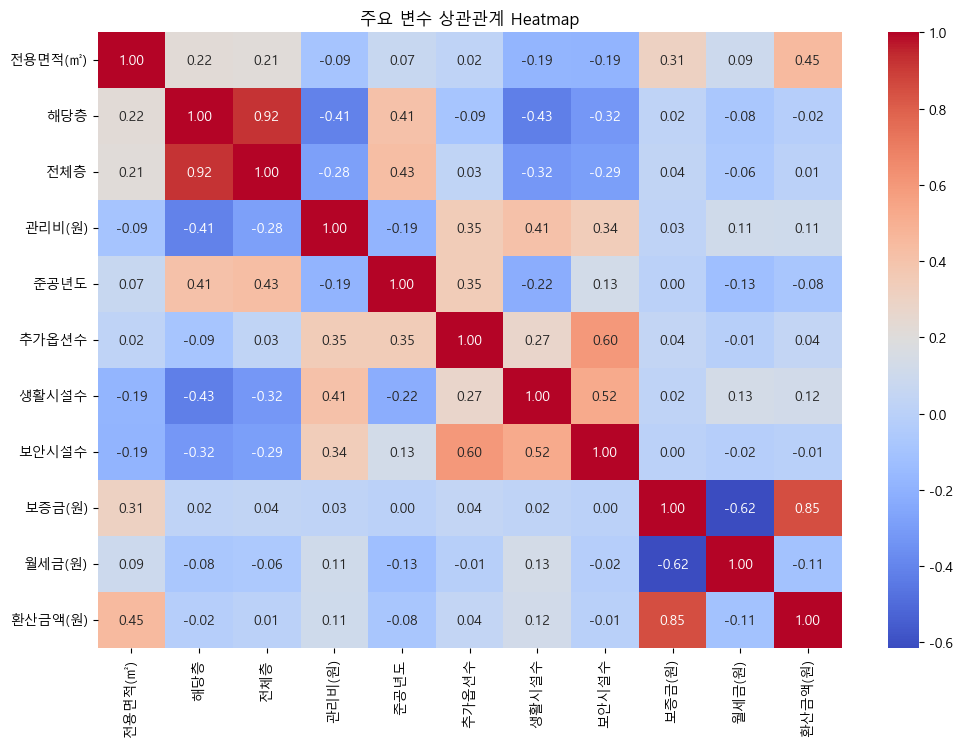

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))
sns.heatmap(corr_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("주요 변수 상관관계 Heatmap")
plt.show()


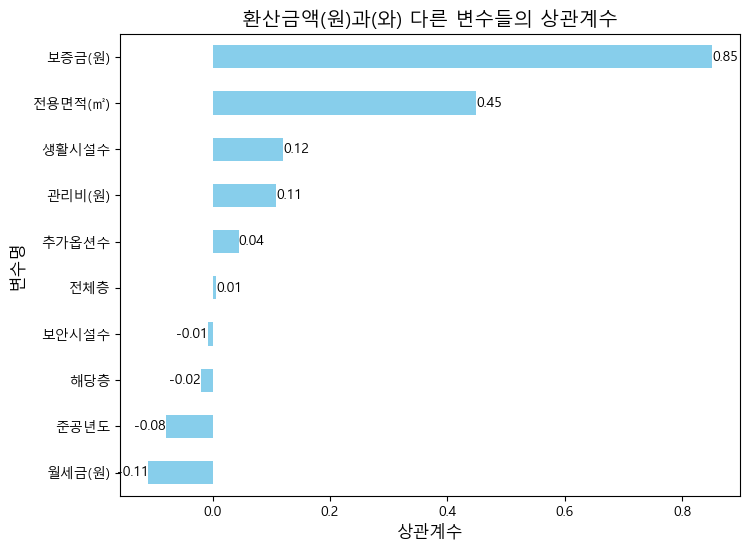

In [45]:
import matplotlib.pyplot as plt

# 목표 변수
target = "환산금액(원)"

# target과의 상관계수 (내림차순 정렬)
corr_series = corr_df.corr()[target].drop(target).sort_values(ascending=True)

plt.figure(figsize=(8,6))
bars = corr_series.plot(kind="barh", color="skyblue")

# 값 표시
for i, v in enumerate(corr_series):
    plt.text(v, i, f"{v:.2f}", va='center', ha='left' if v > 0 else 'right')

# 그래프 제목/축 설정
plt.title(f"{target}과(와) 다른 변수들의 상관계수", fontsize=14)
plt.xlabel("상관계수", fontsize=12)
plt.ylabel("변수명", fontsize=12)

plt.show()


In [41]:
target = "환산금액(원)"  # 환산금액 컬럼명
corr_matrix = corr_df.corr()

# target과의 상관계수만 추출 & 절댓값 기준 상위 N개 고르기
top_corr = corr_matrix[target].drop(target).abs().sort_values(ascending=False).head(3)
print(top_corr)

보증금(원)     0.850772
전용면적(㎡)    0.449476
생활시설수      0.120577
Name: 환산금액(원), dtype: float64


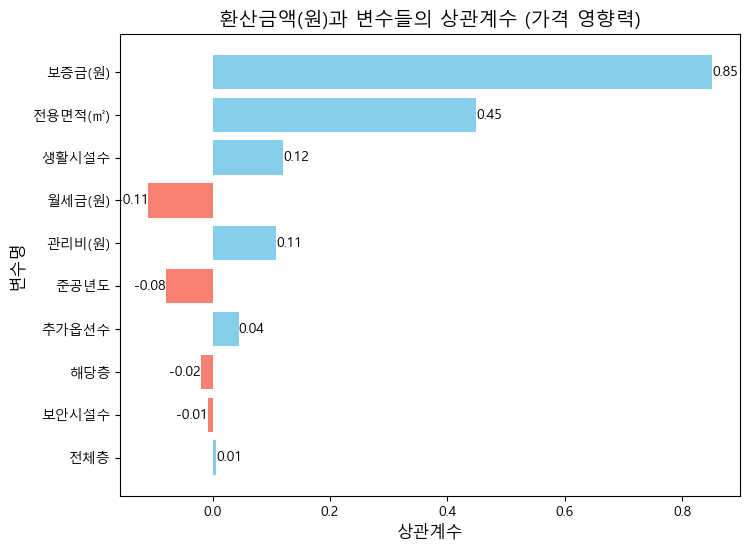

In [49]:
import matplotlib.pyplot as plt

# 목표 변수
target = "환산금액(원)"

# 환산금액과 다른 변수들의 상관계수 추출
corr_series = corr_df.corr()[target].drop(target).sort_values(key=abs, ascending=True)

plt.figure(figsize=(8,6))

# 색깔: 양수/음수 구분
colors = ["skyblue" if v >= 0 else "salmon" for v in corr_series]

# 절댓값으로 정렬된 막대
bars = plt.barh(corr_series.index, corr_series.values, color=colors)

# 값 표시
for i, v in enumerate(corr_series.values):
    plt.text(v, i, f"{v:.2f}", va='center',
             ha='left' if v > 0 else 'right')

# 제목/축
plt.title(f"{target}과 변수들의 상관계수 (가격 영향력)", fontsize=14)
plt.xlabel("상관계수", fontsize=12)
plt.ylabel("변수명", fontsize=12)

plt.show()
